This is a notebook containing a more in-depth analysis and experimentation on the generation of orthogonal feature spaces.
A more direct implementation can be found in [simulation.py](./simulation.py).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV, BandedRidgeCV
from scipy.stats import zscore

In [2]:
np.random.seed(42)
backend = set_backend("cupy")
plt.style.use("nord")
sns.set_theme(style="whitegrid")

In [3]:
n_samples_train = 10000
n_samples_test = 1000
n_targets = 10000
d_list = [100, 100, 100]
scalars = [0.6, 0.2, 0.2]
noise_scalar = 0.1
hidden_feature_space_names = ["A", "B", "C"]
researcher_feature_space_names = [r"$X_1$", r"$X_2$"]

# Generate features

## Start with random matrix $M$

In [4]:
M = np.random.randn(n_samples_train + n_samples_test, sum(d_list))
M = zscore(M, axis=0)

## SVD

In [5]:
U, S, Vt = np.linalg.svd(M, full_matrices=False)
print(U.shape, S.shape, Vt.shape)

(11000, 300) (300,) (300, 300)


Text(7.819444444444452, 0.5, 'value')

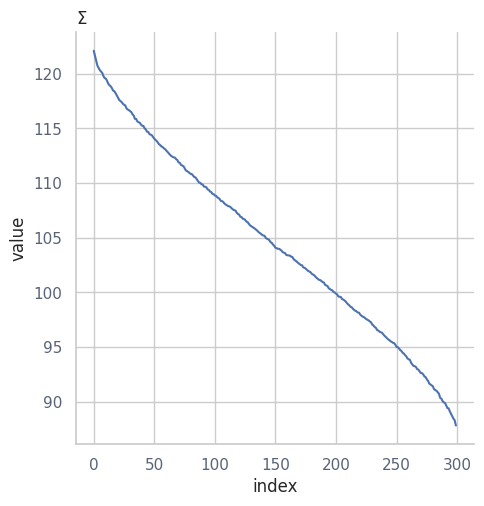

In [6]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$")
plt.xlabel("index")
plt.ylabel("value")

### Shuffle U, S and V indices to remove singular value order

In [7]:
# index_shuffle = list(range(U.shape[1]))
# random.shuffle(index_shuffle)
# U = U[:, index_shuffle]
# S = S[index_shuffle]
# Vt = Vt[index_shuffle, :]

Normalize $\Sigma$

In [8]:
# S = np.ones_like(S)
S = zscore(S)

Text(-0.18055555555554825, 0.5, 'value')

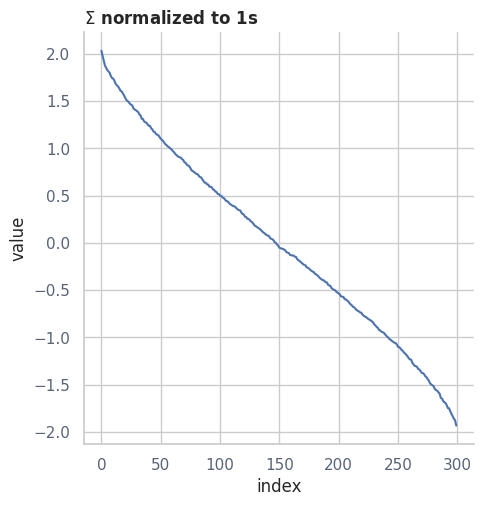

In [9]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$ normalized to 1s")
plt.xlabel("index")
plt.ylabel("value")

Split up S to create three orthogonal matrices to be used as feature spaces

In [10]:
feature_spaces = []

start = 0
for rank in d_list:
    _S = np.zeros(len(S))
    _S[start:start + rank] = S[start:start + rank]

    diag_S = np.diag(_S)

    space = U @ diag_S @ Vt
    space = zscore(space, axis=0)
    feature_spaces.append(space)
    start += rank

#### make sure that all feature spaces are orthogonal to each other (histograms should be nearly 0)

In [11]:
#
# matmuls_df = pd.DataFrame()
#
# for i in range(len(feature_spaces)):
#     for j in range(i + 1, len(feature_spaces)):
#         first_transposed = feature_spaces[i].T @ feature_spaces[
#             j]
#         matmuls_df = pd.concat([
#             matmuls_df,
#             pd.DataFrame(
#                 {'Features': [f"{hidden_feature_space_names[i]}.T x {hidden_feature_space_names[j]}"],
#                  'Values (avg across samples)': [first_transposed.mean(axis=0)]}), ], ignore_index=True)
#
# for i in range(len(feature_spaces)):
#     for j in range(i + 1, len(feature_spaces)):
#         second_transposed = feature_spaces[i] @ feature_spaces[j].T
#         matmuls_df = pd.concat([
#             matmuls_df,
#             pd.DataFrame(
#                 {'Features': [f"{hidden_feature_space_names[i]} x {hidden_feature_space_names[j]}.T"],
#                  'Values (avg across samples)': [second_transposed.mean(axis=0)], }),
#         ], ignore_index=True)
# matmuls_df

In [12]:
# sns.displot(data=matmuls_df.explode("Values (avg across samples)"), x="Values (avg across samples)", multiple="stack",
#             hue="Features", bins=30)
# plt.suptitle("Feature space matrix multiplications", y=1.02)

# Generate weights

In [13]:
betas = [zscore(np.random.randn(sum(d_list), n_targets)) for _ in d_list]

# create targets

In [14]:
Y = sum([(alpha ** 0.5) * zscore(feature_space @ beta) for alpha, feature_space, beta in
         zip(scalars, feature_spaces, betas)])
Y = zscore(Y)

## add noise

In [15]:
noise = zscore(np.random.randn(n_samples_train + n_samples_test, n_targets), axis=0)

In [16]:
Y += noise * (noise_scalar ** 0.5)
Y = zscore(Y)

# train simple linear models to confirm feature spaces predict the target

In [17]:
def r2(prediction, actual):
    ssres = np.sum((prediction - actual) ** 2)
    sstot = np.sum((actual - actual.mean()) ** 2)
    score = 1 - (ssres / sstot)
    return score

In [18]:
scores = pd.DataFrame()

for feature_space, hidden_name, scalar in zip(feature_spaces, hidden_feature_space_names, scalars):
    model = RidgeCV()
    model.fit(feature_space[:n_samples_train], Y[:n_samples_train])
    prediction = model.predict(feature_space[n_samples_train:])
    score = r2(prediction, Y[n_samples_train:])
    scores = pd.concat([
        scores,
        pd.DataFrame({'feature space': [hidden_name], 'Score': [score],
                      'EV': [scalar]})], ignore_index=True
    )

scores

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/backend/_utils.py:138: UserWarning: GPU backend cupy is much faster with single precision floats (float32), got input in float64. Consider casting your data to float32.
  warnings.warn(


,feature space,Score,EV
0,A,0.535283,0.6
1,B,0.167784,0.2
2,C,0.167890,0.2


Text(0.0, 1.0, 'Feature space scores')

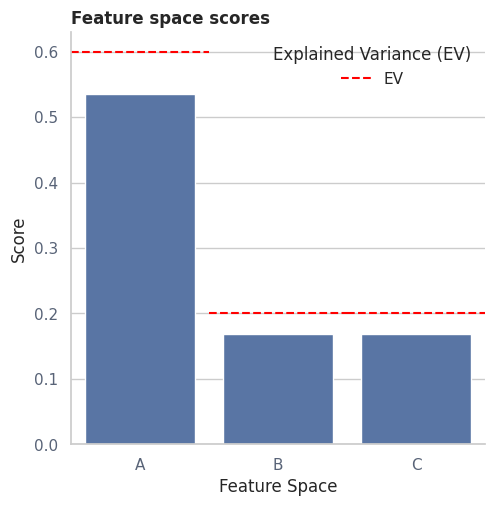

In [19]:
plot = sns.catplot(scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space", "Score")
for index, row in scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 3, xmax=(index + 1) / 3,
                    label=f'EV' if index == 0 else None)
plot.ax.legend(title="Explained Variance (EV)")
plt.title("Feature space scores")

Create researcher feature spaces

In [20]:
Xs = [np.hstack([feature_spaces[0], feature_space]) for feature_space in feature_spaces[1:]]

now train on researcher side feature spaces

In [21]:
researcher_scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(Xs))]
for i, model in enumerate(linear_models):
    model.fit(Xs[i][:n_samples_train], Y[:n_samples_train])
    prediction = model.predict(Xs[i][n_samples_train:])
    score = r2(prediction, Y[n_samples_train:])
    researcher_scores = pd.concat([
        researcher_scores,
        pd.DataFrame({'feature space': [researcher_feature_space_names[i]], 'Score': [score],
                      'EV': scalars[0] + scalars[i + 1]})],
        ignore_index=True
    )
researcher_scores

,feature space,Score,EV
0,$X_1$,0.716884,0.8
1,$X_2$,0.717099,0.8


Text(0.0, 1.0, 'Researcher side feature space scores')

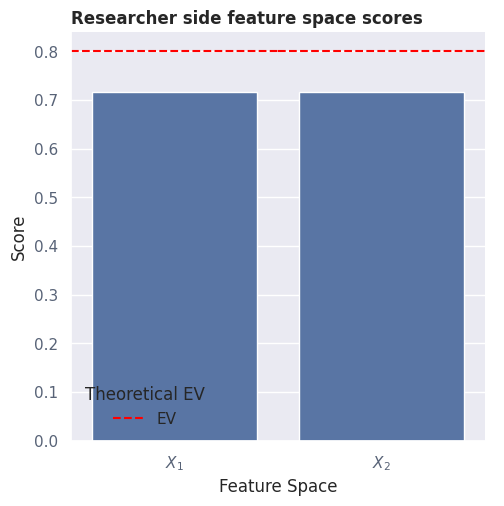

In [22]:
plot = sns.catplot(researcher_scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space",
                                                                                                "Score")
for index, row in researcher_scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 2, xmax=(index + 1) / 2,
                    label=f'EV' if index == 0 else None)
plot.ax.legend(title="Theoretical EV")
plt.title("Researcher side feature space scores")

In [23]:
Xs_train = [x[:n_samples_train] for x in Xs]
Xs_test = [x[n_samples_train:] for x in Xs]
joint_model = BandedRidgeCV(groups="input", solver_params=dict(n_iter=10))
joint_model.fit(Xs_train, Y[:n_samples_train])
score = joint_model.score(Xs_test, Y[n_samples_train:])

[........................................] 100% | 233.49 sec | 10 random sampling with cv | 


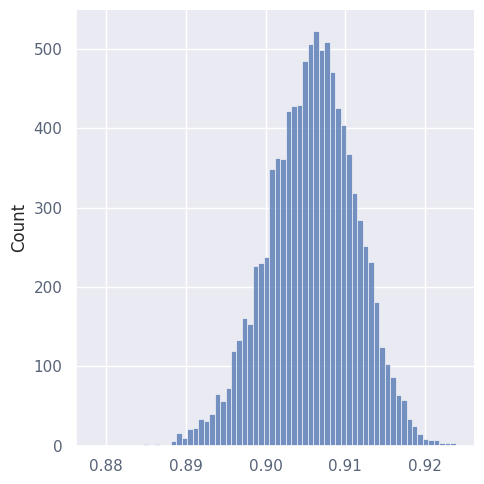

In [24]:
sns.displot(backend.to_numpy(score))